# Identify Top Juniors

In [59]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from datetime import date
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../load_data')
from load import load_stats, load_history

pd.options.mode.chained_assignment = None

## Load Data

In [71]:
players = load_stats()
history = load_history()

juniors = players[(players['Age'] <= timedelta(19*365)) & (players['Tournaments Played'] >= 10)]

## Functions

In [72]:
# True if hit r rating in x time
def r_by_x(player, rating, time):
    try:
        r_hist = history[history['Database#'] == player['Database#']]
        over = r_hist[r_hist['Final Rating'] >= rating]
        if len(over) == 0:
            return False
        
        scope = r_hist.loc[over.index[-1] : r_hist.index[-1]]
        if scope.loc[scope.index[0], 'Start Date'] - scope.loc[scope.index[-1], 'Start Date'] <= time:
            return True
        return False
    except IndexError:
        return pd.NA
    
def is_top_junior(player, male_rating, female_rating):
    if player['Gender'] == 'M':
        age_by_rating = age_by_x(player, male_rating)
    elif player['Gender'] == 'F':
        age_by_rating = age_by_x(player, female_rating)
    else:
        return pd.NA
    
    if age_by_rating is pd.NaT:
        return False
    return age_by_rating < timedelta(days=19*365).days

def age_by_x(player, r):
    try:
        r_hist = history[history['USATT#'] == player['USATT#']]
        scope = r_hist[r_hist['Final Rating'] > r]
        return (scope.loc[scope.index[-1], 'Start Date'] - player['Date of Birth']).days
    except IndexError:
        return pd.NaT
    
def is_us_player(player):
    abbreviations = [
    "AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "IA",
    "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME", "MI", "MN", "MO",
    "MS", "MT", "NC", "ND", "NE", "NH", "NJ", "NM", "NV", "NY", "OH", "OK",
    "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI",
    "WV", "WY", "DC", "AS", "GU", "MP", "PR", "VI"]
    if player['State'] in abbreviations:
        return True
    else:
        return False

In [73]:
me = juniors[juniors['Database#'] == 102103]
age_by_x(me.iloc[0], 2600)

NaT

## Clean Data

In [74]:
juniors['age by 2000'] = juniors.apply(age_by_x, args=(2000,), axis=1)
juniors[juniors['age by 2000'] < 0]

,Rank,First Name,Last Name,Database#,USATT#,Location,Home Club,Tournament Rating,Last Played Tournament,League Rating,...,Membership Expiration,State,Zip,Gender,Date of Birth,Expiration Date,Max Rating,Age,Tournaments Played,age by 2000
1149,1160,Tigran,Tsitoghdzyan,7937,83226,"New York, NY",NaN,2042,2023-11-26,2209,...,ACTIVE,NY,10005,M,2016-05-29,2024-12-01,2133.0,3069 days,65.0,-715


In [75]:
juniors = juniors[juniors['Database#'] != 7937]
history = history.drop_duplicates()

## Analyze Data

In [76]:
juniors['top junior'] = juniors.apply(is_top_junior, args=(2500, 2300), axis=1)

### Percent Data

In [77]:
juniors['x by r'] = juniors.apply(r_by_x, args=(2000, timedelta(4*365)), axis=1)
tt = juniors[(juniors['x by r'] == True) & (juniors['top junior'] == True)]
tf = juniors[(juniors['x by r'] == True) & (juniors['top junior'] == False)]
print(f'tt count: {len(tt)}')
print(f'tf count: {len(tf)}')
print(f'percent: {100 * len(tt) / (len(tt) + len(tf))}')

tt count: 24
tf count: 144
percent: 14.285714285714286


In [11]:
juniors['x by r'] = juniors.apply(r_by_x, args=(2000, timedelta(4*365)), axis=1)
tt = juniors[(juniors['x by r'] == True) & (juniors['top junior'] == True)]
ft = juniors[(juniors['x by r'] == False) & (juniors['top junior'] == True)]
print(f'tt count: {len(tt)}')
print(f'ft count: {len(ft)}')
print(f'percent: {100 * len(tt) / (len(tt) + len(ft))}')

tt count: 24
ft count: 4
percent: 85.71428571428571


### Boxplots

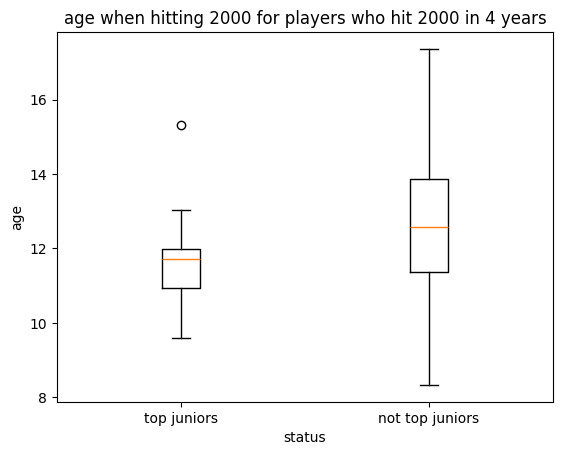

In [12]:
tt['2000 age'] = tt.apply(age_by_x, args=(2000,), axis=1)
tt['2000 years'] = tt['2000 age'] / 365
tf['2000 age'] = tf.apply(age_by_x, args=(2000,), axis=1)
tf['2000 years'] = tf['2000 age'] / 365

plt.boxplot((tt['2000 years'], tf['2000 years']), tick_labels=('top juniors', 'not top juniors'))
plt.title('age when hitting 2000 for players who hit 2000 in 4 years')
plt.xlabel('status')
plt.ylabel('age')
plt.show()

### Top junior progression plots

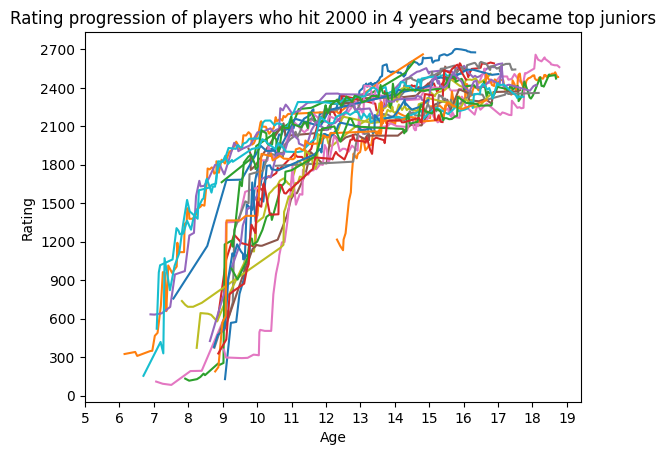

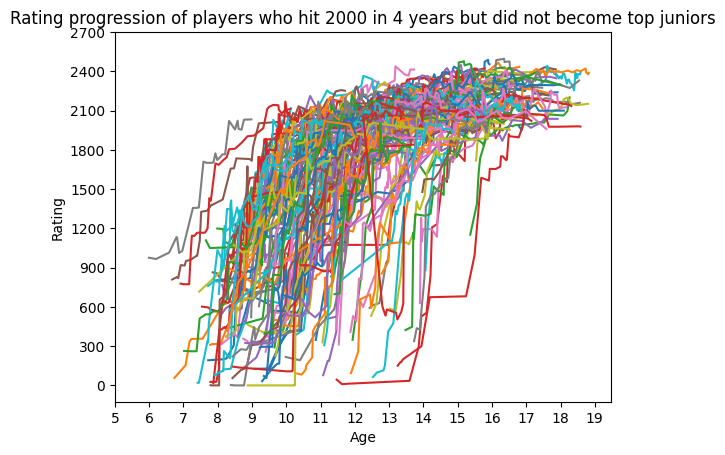

In [13]:
def plot_progression(player):
    rhist = history[history['Database#'] == player['Database#']]
    ages= []
    for date in rhist['Start Date']:
        if (date - player['Date of Birth']).days <= 0:
            return None
        ages.append((date - player['Date of Birth']).days / 365)
    
    plt.plot(ages, rhist['Final Rating'])
    plt.xticks(np.arange(5, 20))
    plt.yticks(np.linspace(0, 2700, 10))
    plt.xlabel('Age')
    plt.ylabel('Rating')

tt.apply(plot_progression, axis=1)
plt.title('Rating progression of players who hit 2000 in 4 years and became top juniors')
plt.show()
tf.apply(plot_progression, axis=1)
plt.title('Rating progression of players who hit 2000 in 4 years but did not become top juniors')
plt.show()

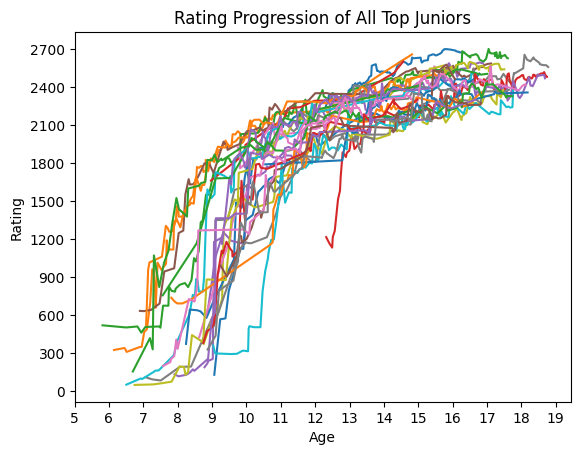

In [14]:
top_juniors = juniors[juniors['top junior'] == True]
top_juniors.apply(plot_progression, axis=1)
plt.title('Rating Progression of All Top Juniors')
plt.show()

In [15]:
boys = juniors[juniors['Gender'] == 'M']
girls = juniors[juniors['Gender'] == 'F']

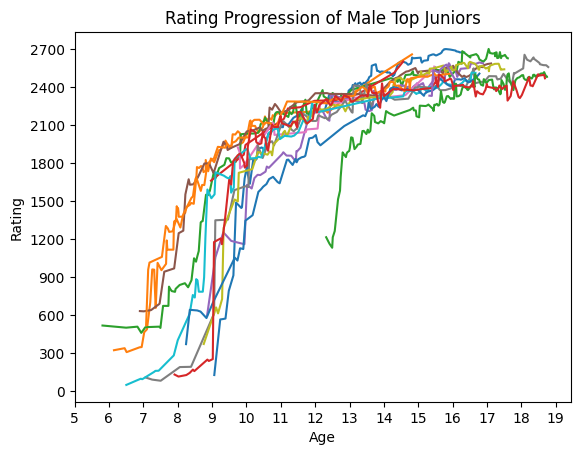

In [16]:
boy_top_juniors = boys[boys['top junior'] == True]
boy_top_juniors.apply(plot_progression, axis=1)
plt.title('Rating Progression of Male Top Juniors')
plt.show()

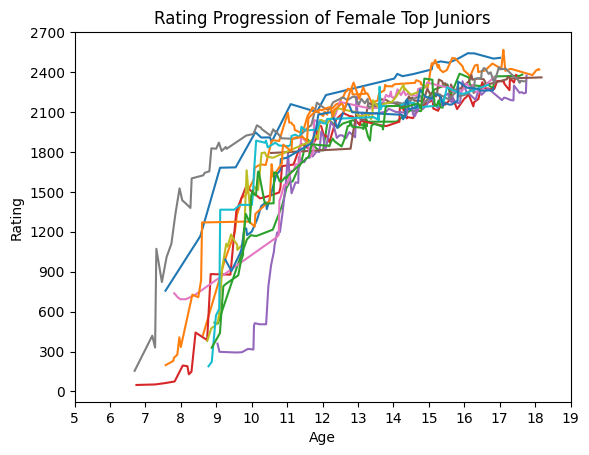

In [17]:
girl_top_juniors = girls[girls['top junior'] == True]
girl_top_juniors.apply(plot_progression, axis=1)
plt.title('Rating Progression of Female Top Juniors')
plt.show()

by percentile

In [18]:
def r_at_a(player, age):
    rhist = history[history['Database#'] == player['Database#']]
    date_range = (player['Date of Birth'] + timedelta(age*365), player['Date of Birth'] + timedelta((age+1)*365))
    rhist_range = rhist[(rhist['Start Date'] <= date_range[1]) & (rhist['Start Date'] >= date_range[0])]
    
    if len(rhist_range) == 0:
        return pd.NA
    return rhist_range.iloc[0, 14]

quantiles = (1.00, 0.90, 0.75, 0.50, 0.25, 0.10)
top_junior_quantiles = pd.DataFrame(columns=['age'] + [f'{quantile} quantile' for quantile in quantiles])
for age in np.arange(6, 19, 0.25):
    age_quantiles = [age]
    for quantile in quantiles:
        r_at_age = top_juniors.apply(r_at_a, args=(age,), axis=1)
        age_quantiles.append(r_at_age.quantile(quantile))
    top_junior_quantiles.loc[len(top_junior_quantiles)] = age_quantiles

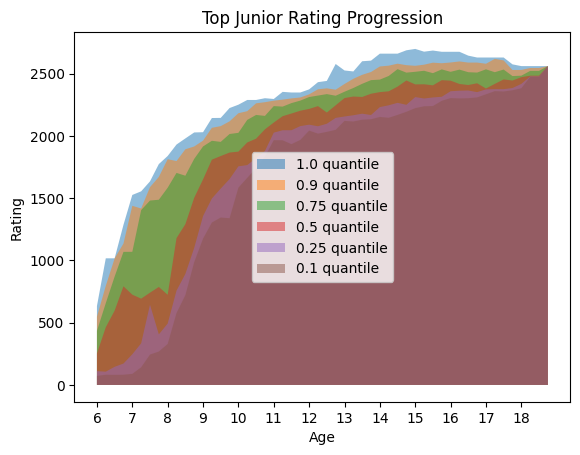

In [19]:
ages = top_junior_quantiles['age']
for quantile in top_junior_quantiles.iloc[:, 1:]:
    plt.fill_between(ages, top_junior_quantiles[quantile], label=quantile, alpha=0.5)

plt.title('Top Junior Rating Progression')
plt.xlabel('Age')
plt.ylabel('Rating')
plt.xticks([age for age in ages if age.is_integer()])
plt.legend()
plt.show()

### max rating by age started

Correlation Coefficient: -0.44821852950979224


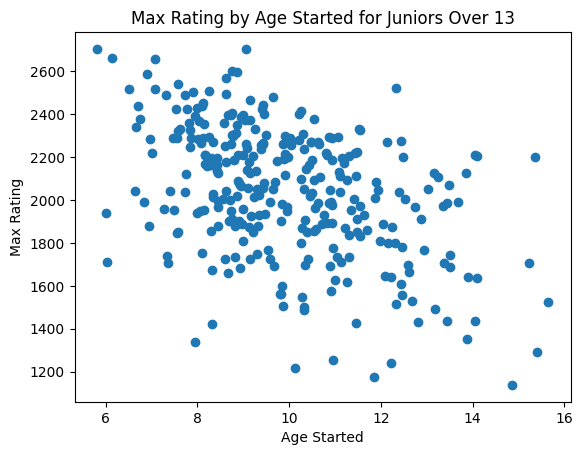

In [20]:
def age_started(player):
    rhist = history[history['Database#'] == player['Database#']]
    return (rhist.iloc[-1, 15] - player['Date of Birth']).days / 365

juniors['age started'] = juniors.apply(age_started, axis=1)
juniors_scope = juniors[(juniors['age started'] > 1) & (juniors['Age'].dt.days > 13*365) & (juniors['Tournaments Played'] > 20) & (juniors['Max Rating'].notna())]

print(f'Correlation Coefficient: {np.corrcoef(juniors_scope['age started'], juniors_scope['Max Rating'])[0][1]}')

plt.scatter(juniors_scope['age started'], juniors_scope['Max Rating'])
plt.title('Max Rating by Age Started for Juniors Over 13')
plt.xlabel('Age Started')
plt.ylabel('Max Rating')
plt.show()

In [21]:
players[players['First Name'] == 'Kanak']

,Rank,First Name,Last Name,Database#,USATT#,Location,Home Club,Tournament Rating,Last Played Tournament,League Rating,Last Played League,Membership Expiration,State,Zip,Gender,Date of Birth,Expiration Date,Max Rating,Age,Tournaments Played
3,4,Kanak,Jha,3431,72193,"Milpitas, CA",888 Table Tennis Center,2806,2024-07-07,2737,2017-04-08,ACTIVE,CA,95035,M,2000-06-19,2100-02-28,2806.0,8892 days,67.0


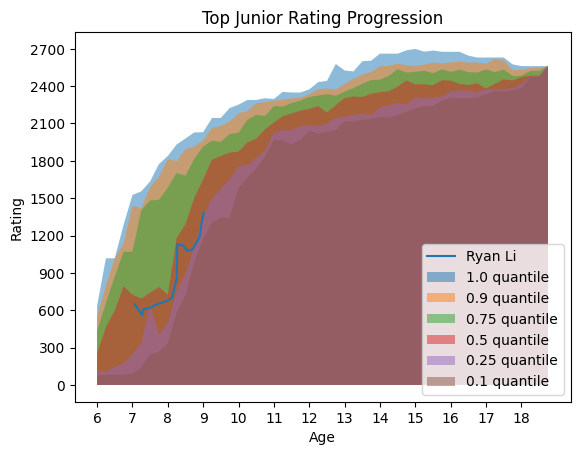

In [22]:
def plot_junior_progression(player):
    rhist = history[history['Database#'] == player['Database#']]
    junior_rhist = rhist[rhist['Start Date'] - player['Date of Birth'] <= timedelta(19*365)]
    ages= []
    for date in junior_rhist['Start Date']:
        if (date - player['Date of Birth']).days <= 0:
            return None
        ages.append((date - player['Date of Birth']).days / 365)
    
    junior_prog, = plt.plot(ages, junior_rhist['Final Rating'], label=junior_rhist.iloc[0, 1] + " " + junior_rhist.iloc[0, 2])
    plt.xticks(np.arange(6, 19))
    plt.yticks(np.linspace(0, 2700, 10))
    plt.xlabel('Age')
    plt.ylabel('Rating')

def plot_to_top_juniors(databaseID):
    plot_junior_progression(players[players['Database#'] == databaseID].iloc[0])

    ages = top_junior_quantiles['age']
    for quantile in top_junior_quantiles.iloc[:, 1:]:
        plt.fill_between(ages, top_junior_quantiles[quantile], label=quantile, alpha=0.5)

    plt.title('Top Junior Rating Progression')
    plt.xlabel('Age')
    plt.ylabel('Rating')
    plt.xticks([age for age in ages if age.is_integer()])
    plt.legend(loc='lower right')

plot_to_top_juniors(176624)
plt.show()

In [67]:
def played_joola_teams(player):
    hist = history[history['Database#'] == player['Database#']]
    if len(hist[hist['Tournament'] == '2023 JOOLA North American Teams']) > 0:
        return True
    return False

def isjunior_teams23(player):
    if datetime(2023, 11, 24) - player['Date of Birth'] < timedelta(18*365):
        return True
    return False

players['teams23 junior'] = players.apply(isjunior_teams23, axis=1)
players['played 2023 teams'] = players.apply(played_joola_teams, axis=1)
teams23 = players[(players['played 2023 teams'] == True) & (players['teams23 junior'] == True)]

In [78]:
len(players[players.apply(played_joola_teams, axis=1)])

882

In [ ]:
teams23hist = history[history['Tournament'] == '2023 JOOLA North American Teams']
teams23hist['Rating Change'] = teams23hist['Final Rating'] - teams23hist['Initial Rating']
teams23hist

,Rank,First Name,Last Name,Database#,USATT#,Location,Home Club,Tournament Rating,Last Played Tournament,League Rating,Last Played League,Membership Expiration,Tournament,Initial Rating,Final Rating,Start Date,End Date,Rating Change
8,2,Lei,Kou,165420,1165420,"Milpitas, CA",Kou Lei Table Tennis Club,2810,2024-04-07,2816,2022-08-28,ACTIVE,2023 JOOLA North American Teams,2800.0,2814.0,2023-11-24,2023-11-26,14.0
71,3,Enzo,Angles,169130,1169130,"Vila Nova De Gaia, FN",NaN,2808,2024-09-08,0,NaT,ACTIVE,2023 JOOLA North American Teams,2761.0,2772.0,2023-11-24,2023-11-26,11.0
175,5,Jinbao,Ma,121283,220283,"Sunnyvale, CA",NaN,2774,2024-09-02,2723,2022-10-02,ACTIVE,2023 JOOLA North American Teams,2752.0,2746.0,2023-11-24,2023-11-26,-6.0
362,9,Jishan,Liang,4482,86560,"Cary, NC",NC International Table Tennis (NCITT),2746,2024-08-04,2648,2015-06-02,ACTIVE,2023 JOOLA North American Teams,2712.0,2707.0,2023-11-24,2023-11-26,-5.0
609,11,Taehyun,Kim,182757,1182757,NaN,NaN,2735,2024-09-08,0,NaT,ACTIVE,2023 JOOLA North American Teams,0.0,2798.0,2023-11-24,2023-11-26,2798.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194667,10100,Justin,Wang,182525,281525,"LIVINGSTON, NJ",Matchpoint Table Tennis Center NJ,367,2023-11-26,0,NaT,ACTIVE,2023 JOOLA North American Teams,0.0,367.0,2023-11-24,2023-11-26,367.0
194749,10129,Jolie,Hu,181703,280703,NaN,NaN,345,2024-05-05,0,NaT,ACTIVE,2023 JOOLA North American Teams,0.0,305.0,2023-11-24,2023-11-26,305.0
194808,10152,Daniel,Dong,182453,281453,"Little Neck, NY",Origin Table Tennis Academy,324,2023-11-26,0,NaT,ACTIVE,2023 JOOLA North American Teams,0.0,324.0,2023-11-24,2023-11-26,324.0
194838,10164,Aileen,Zhang,182223,281223,NaN,NaN,316,2023-11-26,0,NaT,ACTIVE,2023 JOOLA North American Teams,0.0,316.0,2023-11-24,2023-11-26,316.0


In [52]:
teams23hist['Rating Change'].describe()

count     883.000000
mean      108.748584
std       305.835424
min      -665.000000
25%       -16.000000
50%        37.000000
75%       121.500000
max      2798.000000
Name: Rating Change, dtype: float64

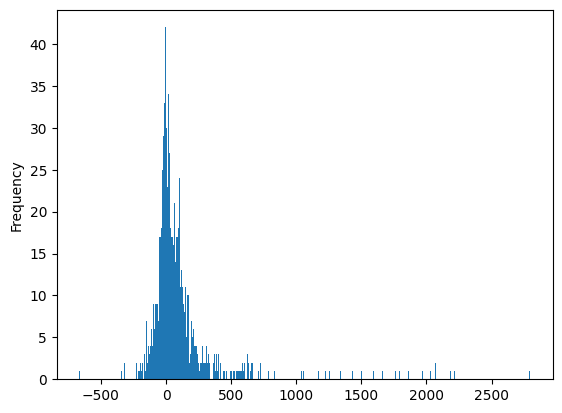

In [58]:
teams23hist['Rating Change'].plot.hist(bins=500);